In [1]:
!pip install torchsummary
!pip install albumentations
from torchsummary import summary

     |████████████████████████████████| 123 kB 32.7 MB/s eta 0:00:01
     |████████████████████████████████| 49.2 MB 86.8 MB/s eta 0:00:01


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import models.model as md
import config as cf
import utils as utils
import plottingUtils as pt
import dataUtils as du
from torch.utils.data import DataLoader, Dataset
from PIL import Image

## define the function to get the dataset
the dataset wil be augmented by the albumentations 

In [6]:
def getDataSet():
  # transform_train = transforms.Compose(
  #   [transforms.ToTensor(),
  #    transforms.RandomRotation((-18.0, 18.0)),
  #    transforms.RandomHorizontalFlip(p=0.5),
  #    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  
  aug_train = A.Compose({
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1,max_width=16,max_height=16,
                        min_height=1,min_width=1,min_holes = 1,
                        mask_fill_value=None,fill_value=0.5),
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        })

  transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True)
  pytorch_train_dataset = du.PyTorchImageDataset(trainset,
                                              datasetType="Train",
                                              transformations=aug_train)
  pytorch_train_dataloader = DataLoader(dataset=pytorch_train_dataset, 
                                        batch_size=cf.Args.batch_size, 
                                        num_workers=cf.Args.num_workers,
                                        pin_memory=True,
                                        shuffle=True) 

  # train_loader = torch.utils.data.DataLoader(trainset, batch_size=32,
  #                                           shuffle=True, num_workers=4, pin_memory=True)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True)
  pytorch_test_dataset = du.PyTorchImageDataset(testset,
                                             datasetType="Test",
                                             transformations=transform_test)
  # test_loader = torch.utils.data.DataLoader(testset, batch_size=32,
  #                                          shuffle=False, num_workers=4, pin_memory=True)


  pytorch_test_dataloader = DataLoader(dataset=pytorch_test_dataset, 
                                       batch_size=cf.Args.batch_size, 
                                       shuffle=True,
                                       num_workers=cf.Args.num_workers,
                                       pin_memory=True,)
  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  return pytorch_train_dataloader,pytorch_test_dataloader,classes

## lets check what are we reading

In [11]:
# Initialize CUDA and set random seed
isCuda, device = utils.initialize_cuda(cf.Args.random_seed)

GPU Available? True


Files already downloaded and verified
Files already downloaded and verified
Trainging Images
Testing Images


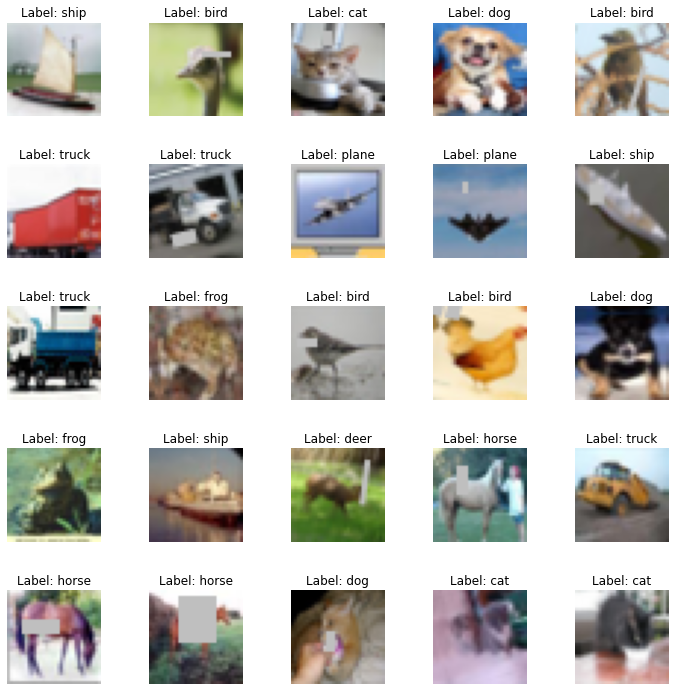

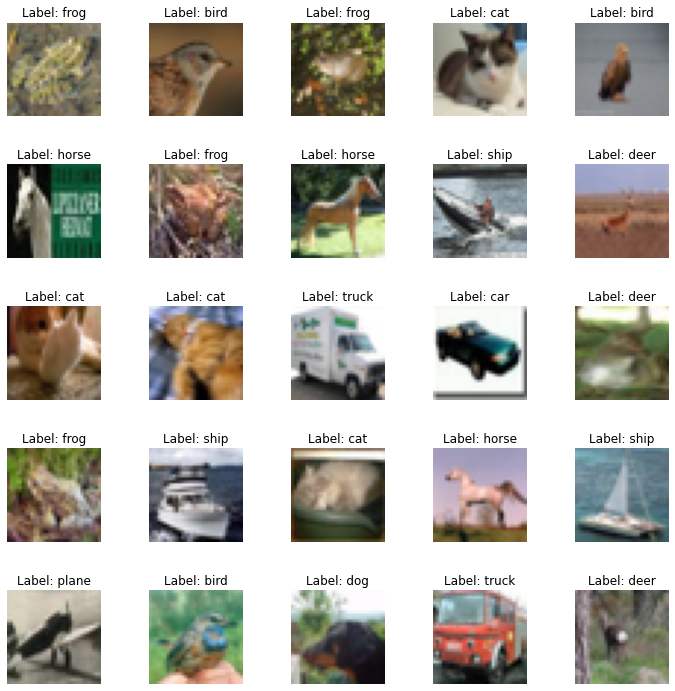

In [13]:
train_loader,test_loader,classes=getDataSet()
print("Trainging Images")
pt.plotSampleImages(train_loader,classes)
print("Testing Images")
pt.plotSampleImages(test_loader,classes)

## Get the model

In [14]:
## get the model
model = md.Net(cf.Args.dropout,"BN").to(device)  # Create model
summary(model, (3,32,32))  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 15, 15]          36,928
              ReLU-6           [-1, 64, 15, 15]               0
       BatchNorm2d-7           [-1, 64, 15, 15]             128
           Dropout-8           [-1, 64, 15, 15]               0
            Conv2d-9           [-1, 32, 15, 15]           2,080
           Conv2d-10           [-1, 64, 15, 15]          18,496
             ReLU-11           [-1, 64, 15, 15]               0
      BatchNorm2d-12           [-1, 64, 15, 15]             128
          Dropout-13           [-1, 64, 15, 15]               0
           Conv2d-14             [-1, 6

## training & evaluation

In [15]:
losses = []
accuracies = []
incorrect_samples = []

criterion = utils.cross_entropy_loss()  # Create loss function
optimizer = utils.sgd_optimizer(model, cf.Args.learning_rate, cf.Args.momentum)  # Create optimizer

for epoch in range(1, 100):
    print(f'Epoch {epoch}:')
    utils.train(model, train_loader, device, optimizer, criterion)
    utils.eval(model, test_loader, device, criterion, losses, accuracies, incorrect_samples)

Epoch 1:


Loss=1.23 Batch_ID=1562 Accuracy=38.67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.72it/s]



Test set: Average loss: 0.0418, Test Accuracy: 5074/10000 (50.74%)

Epoch 2:


Loss=1.26 Batch_ID=1562 Accuracy=49.13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.98it/s]



Test set: Average loss: 0.0352, Test Accuracy: 5937/10000 (59.37%)

Epoch 3:


Loss=1.18 Batch_ID=1562 Accuracy=55.39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.05it/s]



Test set: Average loss: 0.0321, Test Accuracy: 6309/10000 (63.09%)

Epoch 4:


Loss=0.87 Batch_ID=1562 Accuracy=59.04: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 139.58it/s]



Test set: Average loss: 0.0287, Test Accuracy: 6682/10000 (66.82%)

Epoch 5:


Loss=0.82 Batch_ID=1562 Accuracy=62.30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 139.40it/s]



Test set: Average loss: 0.0268, Test Accuracy: 6986/10000 (69.86%)

Epoch 6:


Loss=0.76 Batch_ID=1562 Accuracy=64.33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.17it/s]



Test set: Average loss: 0.0264, Test Accuracy: 7060/10000 (70.60%)

Epoch 7:


Loss=1.24 Batch_ID=1562 Accuracy=66.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.48it/s]



Test set: Average loss: 0.0244, Test Accuracy: 7264/10000 (72.64%)

Epoch 8:


Loss=1.15 Batch_ID=1562 Accuracy=67.30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.35it/s]



Test set: Average loss: 0.0234, Test Accuracy: 7377/10000 (73.77%)

Epoch 9:


Loss=0.66 Batch_ID=1562 Accuracy=68.37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.73it/s]



Test set: Average loss: 0.0224, Test Accuracy: 7521/10000 (75.21%)

Epoch 10:


Loss=1.07 Batch_ID=1562 Accuracy=68.99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 135.60it/s]



Test set: Average loss: 0.0222, Test Accuracy: 7524/10000 (75.24%)

Epoch 11:


Loss=0.47 Batch_ID=1562 Accuracy=70.07: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.76it/s]



Test set: Average loss: 0.0213, Test Accuracy: 7609/10000 (76.09%)

Epoch 12:


Loss=1.17 Batch_ID=1562 Accuracy=70.78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 138.26it/s]



Test set: Average loss: 0.0214, Test Accuracy: 7609/10000 (76.09%)

Epoch 13:


Loss=0.99 Batch_ID=1562 Accuracy=71.01: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 138.36it/s]



Test set: Average loss: 0.0206, Test Accuracy: 7747/10000 (77.47%)

Epoch 14:


Loss=0.96 Batch_ID=1562 Accuracy=71.70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 138.09it/s]



Test set: Average loss: 0.0200, Test Accuracy: 7802/10000 (78.02%)

Epoch 15:


Loss=1.49 Batch_ID=1562 Accuracy=72.25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.92it/s]



Test set: Average loss: 0.0197, Test Accuracy: 7823/10000 (78.23%)

Epoch 16:


Loss=0.72 Batch_ID=1562 Accuracy=72.90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.73it/s]



Test set: Average loss: 0.0194, Test Accuracy: 7876/10000 (78.76%)

Epoch 17:


Loss=0.74 Batch_ID=1562 Accuracy=73.03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.57it/s]



Test set: Average loss: 0.0189, Test Accuracy: 7946/10000 (79.46%)

Epoch 18:


Loss=0.78 Batch_ID=1562 Accuracy=73.56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.22it/s]



Test set: Average loss: 0.0185, Test Accuracy: 7982/10000 (79.82%)

Epoch 19:


Loss=1.16 Batch_ID=1562 Accuracy=73.99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.26it/s]



Test set: Average loss: 0.0192, Test Accuracy: 7871/10000 (78.71%)

Epoch 20:


Loss=0.83 Batch_ID=1562 Accuracy=74.51: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 139.07it/s]



Test set: Average loss: 0.0185, Test Accuracy: 7981/10000 (79.81%)

Epoch 21:


Loss=0.75 Batch_ID=1562 Accuracy=74.90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 138.72it/s]



Test set: Average loss: 0.0181, Test Accuracy: 7986/10000 (79.86%)

Epoch 22:


Loss=1.13 Batch_ID=1562 Accuracy=74.83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.24it/s]



Test set: Average loss: 0.0173, Test Accuracy: 8103/10000 (81.03%)

Epoch 23:


Loss=0.64 Batch_ID=1562 Accuracy=75.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.26it/s]



Test set: Average loss: 0.0170, Test Accuracy: 8108/10000 (81.08%)

Epoch 24:


Loss=1.17 Batch_ID=1562 Accuracy=75.84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.02it/s]



Test set: Average loss: 0.0172, Test Accuracy: 8121/10000 (81.21%)

Epoch 25:


Loss=0.90 Batch_ID=1562 Accuracy=75.65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.44it/s]



Test set: Average loss: 0.0167, Test Accuracy: 8191/10000 (81.91%)

Epoch 26:


Loss=0.58 Batch_ID=1562 Accuracy=75.68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.49it/s]



Test set: Average loss: 0.0173, Test Accuracy: 8081/10000 (80.81%)

Epoch 27:


Loss=0.39 Batch_ID=1562 Accuracy=76.14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.76it/s]



Test set: Average loss: 0.0166, Test Accuracy: 8179/10000 (81.79%)

Epoch 28:


Loss=0.69 Batch_ID=1562 Accuracy=76.26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 139.88it/s]



Test set: Average loss: 0.0168, Test Accuracy: 8175/10000 (81.75%)

Epoch 29:


Loss=0.58 Batch_ID=1562 Accuracy=76.59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.95it/s]



Test set: Average loss: 0.0164, Test Accuracy: 8179/10000 (81.79%)

Epoch 30:


Loss=0.37 Batch_ID=1562 Accuracy=77.02: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.91it/s]



Test set: Average loss: 0.0161, Test Accuracy: 8244/10000 (82.44%)

Epoch 31:


Loss=1.36 Batch_ID=1562 Accuracy=77.02: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.76it/s]



Test set: Average loss: 0.0161, Test Accuracy: 8258/10000 (82.58%)

Epoch 32:


Loss=0.43 Batch_ID=1562 Accuracy=77.19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.57it/s]



Test set: Average loss: 0.0156, Test Accuracy: 8299/10000 (82.99%)

Epoch 33:


Loss=0.55 Batch_ID=1562 Accuracy=77.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.74it/s]



Test set: Average loss: 0.0159, Test Accuracy: 8273/10000 (82.73%)

Epoch 34:


Loss=0.34 Batch_ID=1562 Accuracy=77.60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.85it/s]



Test set: Average loss: 0.0159, Test Accuracy: 8287/10000 (82.87%)

Epoch 35:


Loss=0.29 Batch_ID=1562 Accuracy=77.60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.66it/s]



Test set: Average loss: 0.0155, Test Accuracy: 8267/10000 (82.67%)

Epoch 36:


Loss=0.64 Batch_ID=1562 Accuracy=77.82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 139.70it/s]



Test set: Average loss: 0.0156, Test Accuracy: 8306/10000 (83.06%)

Epoch 37:


Loss=0.49 Batch_ID=1562 Accuracy=77.92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 138.53it/s]



Test set: Average loss: 0.0151, Test Accuracy: 8322/10000 (83.22%)

Epoch 38:


Loss=0.54 Batch_ID=1562 Accuracy=78.23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.70it/s]



Test set: Average loss: 0.0153, Test Accuracy: 8339/10000 (83.39%)

Epoch 39:


Loss=0.89 Batch_ID=1562 Accuracy=78.10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.21it/s]



Test set: Average loss: 0.0151, Test Accuracy: 8344/10000 (83.44%)

Epoch 40:


Loss=1.15 Batch_ID=1562 Accuracy=78.41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 135.99it/s]



Test set: Average loss: 0.0150, Test Accuracy: 8376/10000 (83.76%)

Epoch 41:


Loss=0.28 Batch_ID=1562 Accuracy=78.33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 135.52it/s]



Test set: Average loss: 0.0148, Test Accuracy: 8369/10000 (83.69%)

Epoch 42:


Loss=0.72 Batch_ID=1562 Accuracy=78.63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.73it/s]



Test set: Average loss: 0.0151, Test Accuracy: 8336/10000 (83.36%)

Epoch 43:


Loss=0.81 Batch_ID=1562 Accuracy=78.63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.81it/s]



Test set: Average loss: 0.0150, Test Accuracy: 8355/10000 (83.55%)

Epoch 44:


Loss=1.55 Batch_ID=1562 Accuracy=78.71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 139.28it/s]



Test set: Average loss: 0.0146, Test Accuracy: 8413/10000 (84.13%)

Epoch 45:


Loss=0.72 Batch_ID=1562 Accuracy=78.91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 138.46it/s]



Test set: Average loss: 0.0149, Test Accuracy: 8355/10000 (83.55%)

Epoch 46:


Loss=0.40 Batch_ID=1562 Accuracy=79.03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.85it/s]



Test set: Average loss: 0.0151, Test Accuracy: 8354/10000 (83.54%)

Epoch 47:


Loss=1.09 Batch_ID=1562 Accuracy=79.38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.17it/s]



Test set: Average loss: 0.0145, Test Accuracy: 8421/10000 (84.21%)

Epoch 48:


Loss=0.55 Batch_ID=1562 Accuracy=79.16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.03it/s]



Test set: Average loss: 0.0146, Test Accuracy: 8413/10000 (84.13%)

Epoch 49:


Loss=1.24 Batch_ID=1562 Accuracy=79.53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.44it/s]



Test set: Average loss: 0.0151, Test Accuracy: 8329/10000 (83.29%)

Epoch 50:


Loss=0.40 Batch_ID=1562 Accuracy=79.42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.76it/s]



Test set: Average loss: 0.0143, Test Accuracy: 8431/10000 (84.31%)

Epoch 51:


Loss=0.47 Batch_ID=1562 Accuracy=79.60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.57it/s]



Test set: Average loss: 0.0142, Test Accuracy: 8472/10000 (84.72%)

Epoch 52:


Loss=0.88 Batch_ID=1562 Accuracy=79.41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 140.40it/s]



Test set: Average loss: 0.0145, Test Accuracy: 8438/10000 (84.38%)

Epoch 53:


Loss=0.45 Batch_ID=1562 Accuracy=79.83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.35it/s]



Test set: Average loss: 0.0143, Test Accuracy: 8450/10000 (84.50%)

Epoch 54:


Loss=0.57 Batch_ID=1562 Accuracy=79.92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.83it/s]



Test set: Average loss: 0.0146, Test Accuracy: 8387/10000 (83.87%)

Epoch 55:


Loss=0.97 Batch_ID=1562 Accuracy=79.98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.85it/s]



Test set: Average loss: 0.0144, Test Accuracy: 8439/10000 (84.39%)

Epoch 56:


Loss=0.29 Batch_ID=1562 Accuracy=80.13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.49it/s]



Test set: Average loss: 0.0137, Test Accuracy: 8503/10000 (85.03%)

Epoch 57:


Loss=0.52 Batch_ID=1562 Accuracy=80.07: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.24it/s]



Test set: Average loss: 0.0139, Test Accuracy: 8506/10000 (85.06%)

Epoch 58:


Loss=0.32 Batch_ID=1562 Accuracy=80.13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.13it/s]



Test set: Average loss: 0.0137, Test Accuracy: 8531/10000 (85.31%)

Epoch 59:


Loss=0.68 Batch_ID=1562 Accuracy=80.42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 138.01it/s]



Test set: Average loss: 0.0138, Test Accuracy: 8510/10000 (85.10%)

Epoch 60:


Loss=0.66 Batch_ID=1562 Accuracy=80.29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 140.52it/s]



Test set: Average loss: 0.0144, Test Accuracy: 8458/10000 (84.58%)

Epoch 61:


Loss=0.58 Batch_ID=1562 Accuracy=80.36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.99it/s]



Test set: Average loss: 0.0140, Test Accuracy: 8479/10000 (84.79%)

Epoch 62:


Loss=0.75 Batch_ID=1562 Accuracy=80.55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.11it/s]



Test set: Average loss: 0.0137, Test Accuracy: 8517/10000 (85.17%)

Epoch 63:


Loss=0.15 Batch_ID=1562 Accuracy=80.40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.73it/s]



Test set: Average loss: 0.0134, Test Accuracy: 8525/10000 (85.25%)

Epoch 64:


Loss=0.61 Batch_ID=1562 Accuracy=80.67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.03it/s]



Test set: Average loss: 0.0138, Test Accuracy: 8469/10000 (84.69%)

Epoch 65:


Loss=0.90 Batch_ID=1562 Accuracy=80.82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.63it/s]



Test set: Average loss: 0.0132, Test Accuracy: 8543/10000 (85.43%)

Epoch 66:


Loss=0.51 Batch_ID=1562 Accuracy=80.95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.91it/s]



Test set: Average loss: 0.0133, Test Accuracy: 8531/10000 (85.31%)

Epoch 67:


Loss=0.46 Batch_ID=1562 Accuracy=80.88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 139.59it/s]



Test set: Average loss: 0.0138, Test Accuracy: 8484/10000 (84.84%)

Epoch 68:


Loss=0.28 Batch_ID=1562 Accuracy=80.98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 138.99it/s]



Test set: Average loss: 0.0135, Test Accuracy: 8534/10000 (85.34%)

Epoch 69:


Loss=1.37 Batch_ID=1562 Accuracy=81.08: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.81it/s]



Test set: Average loss: 0.0136, Test Accuracy: 8513/10000 (85.13%)

Epoch 70:


Loss=0.62 Batch_ID=1562 Accuracy=80.80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.59it/s]



Test set: Average loss: 0.0134, Test Accuracy: 8561/10000 (85.61%)

Epoch 71:


Loss=0.54 Batch_ID=1562 Accuracy=81.40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.75it/s]



Test set: Average loss: 0.0134, Test Accuracy: 8520/10000 (85.20%)

Epoch 72:


Loss=0.55 Batch_ID=1562 Accuracy=81.11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.48it/s]



Test set: Average loss: 0.0129, Test Accuracy: 8562/10000 (85.62%)

Epoch 73:


Loss=1.04 Batch_ID=1562 Accuracy=81.09: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.59it/s]



Test set: Average loss: 0.0132, Test Accuracy: 8561/10000 (85.61%)

Epoch 74:


Loss=1.03 Batch_ID=1562 Accuracy=81.30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.55it/s]



Test set: Average loss: 0.0132, Test Accuracy: 8560/10000 (85.60%)

Epoch 75:


Loss=1.23 Batch_ID=1562 Accuracy=81.24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 139.63it/s]



Test set: Average loss: 0.0134, Test Accuracy: 8540/10000 (85.40%)

Epoch 76:


Loss=0.46 Batch_ID=1562 Accuracy=81.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 138.92it/s]



Test set: Average loss: 0.0136, Test Accuracy: 8521/10000 (85.21%)

Epoch 77:


Loss=0.48 Batch_ID=1562 Accuracy=81.60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.45it/s]



Test set: Average loss: 0.0131, Test Accuracy: 8552/10000 (85.52%)

Epoch 78:


Loss=0.48 Batch_ID=1562 Accuracy=81.52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.76it/s]



Test set: Average loss: 0.0132, Test Accuracy: 8544/10000 (85.44%)

Epoch 79:


Loss=0.82 Batch_ID=1562 Accuracy=81.53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.47it/s]



Test set: Average loss: 0.0133, Test Accuracy: 8547/10000 (85.47%)

Epoch 80:


Loss=0.85 Batch_ID=1562 Accuracy=81.63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.46it/s]



Test set: Average loss: 0.0134, Test Accuracy: 8541/10000 (85.41%)

Epoch 81:


Loss=0.38 Batch_ID=1562 Accuracy=81.26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.08it/s]



Test set: Average loss: 0.0127, Test Accuracy: 8601/10000 (86.01%)

Epoch 82:


Loss=1.04 Batch_ID=1562 Accuracy=81.29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.18it/s]



Test set: Average loss: 0.0131, Test Accuracy: 8552/10000 (85.52%)

Epoch 83:


Loss=0.82 Batch_ID=1562 Accuracy=81.53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 138.42it/s]



Test set: Average loss: 0.0128, Test Accuracy: 8577/10000 (85.77%)

Epoch 84:


Loss=0.41 Batch_ID=1562 Accuracy=81.98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.90it/s]



Test set: Average loss: 0.0131, Test Accuracy: 8562/10000 (85.62%)

Epoch 85:


Loss=0.24 Batch_ID=1562 Accuracy=82.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.85it/s]



Test set: Average loss: 0.0131, Test Accuracy: 8565/10000 (85.65%)

Epoch 86:


Loss=0.63 Batch_ID=1562 Accuracy=82.01: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.48it/s]



Test set: Average loss: 0.0128, Test Accuracy: 8605/10000 (86.05%)

Epoch 87:


Loss=0.37 Batch_ID=1562 Accuracy=82.09: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.79it/s]



Test set: Average loss: 0.0128, Test Accuracy: 8595/10000 (85.95%)

Epoch 88:


Loss=0.19 Batch_ID=1562 Accuracy=81.77: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.15it/s]



Test set: Average loss: 0.0125, Test Accuracy: 8614/10000 (86.14%)

Epoch 89:


Loss=0.77 Batch_ID=1562 Accuracy=82.18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.11it/s]



Test set: Average loss: 0.0129, Test Accuracy: 8605/10000 (86.05%)

Epoch 90:


Loss=0.47 Batch_ID=1562 Accuracy=82.24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.59it/s]



Test set: Average loss: 0.0124, Test Accuracy: 8638/10000 (86.38%)

Epoch 91:


Loss=0.35 Batch_ID=1562 Accuracy=82.07: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 139.37it/s]



Test set: Average loss: 0.0127, Test Accuracy: 8620/10000 (86.20%)

Epoch 92:


Loss=0.65 Batch_ID=1562 Accuracy=81.69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.54it/s]



Test set: Average loss: 0.0130, Test Accuracy: 8578/10000 (85.78%)

Epoch 93:


Loss=0.48 Batch_ID=1562 Accuracy=82.10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.97it/s]



Test set: Average loss: 0.0125, Test Accuracy: 8613/10000 (86.13%)

Epoch 94:


Loss=0.56 Batch_ID=1562 Accuracy=82.15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.93it/s]



Test set: Average loss: 0.0125, Test Accuracy: 8619/10000 (86.19%)

Epoch 95:


Loss=0.78 Batch_ID=1562 Accuracy=82.26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.92it/s]



Test set: Average loss: 0.0124, Test Accuracy: 8642/10000 (86.42%)

Epoch 96:


Loss=0.63 Batch_ID=1562 Accuracy=82.24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 135.75it/s]



Test set: Average loss: 0.0126, Test Accuracy: 8654/10000 (86.54%)

Epoch 97:


Loss=0.22 Batch_ID=1562 Accuracy=82.47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 136.21it/s]



Test set: Average loss: 0.0125, Test Accuracy: 8640/10000 (86.40%)

Epoch 98:


Loss=0.48 Batch_ID=1562 Accuracy=82.37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 137.44it/s]



Test set: Average loss: 0.0124, Test Accuracy: 8654/10000 (86.54%)

Epoch 99:


Loss=0.29 Batch_ID=1562 Accuracy=82.43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:11<00:00, 138.88it/s]



Test set: Average loss: 0.0123, Test Accuracy: 8654/10000 (86.54%)



## Draw the curves

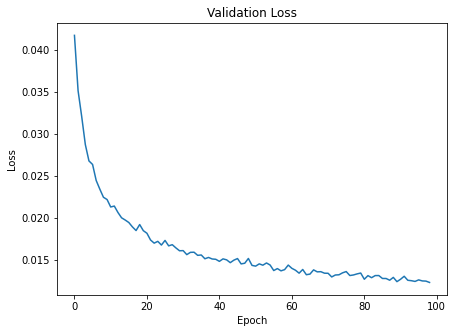

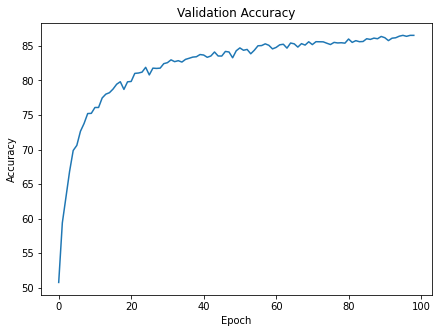

In [18]:
pt.plot_metric(losses, 'Loss')
pt.plot_metric(accuracies, 'Accuracy')

## Check the misclassifications

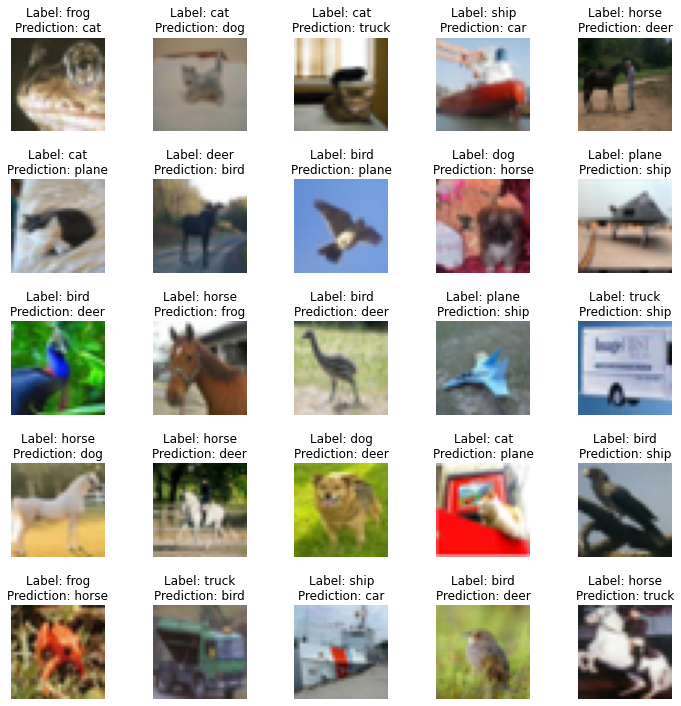

In [19]:
pt.save_and_show_result(incorrect_samples, classes)

## Summary of the class level accuracy

In [20]:
pt.class_level_accuracy(model, test_loader, device, classes)

Accuracy of plane : 86 %
Accuracy of   car : 94 %
Accuracy of  bird : 81 %
Accuracy of   cat : 72 %
Accuracy of  deer : 86 %
Accuracy of   dog : 78 %
Accuracy of  frog : 88 %
Accuracy of horse : 90 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %
